In [1]:
import numpy as np
import os
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from scipy.signal import lfilter
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import parselmouth
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv(r"C:\Users\jmdgo\Downloads\binary_labeled_dataset.csv")

In [3]:
clip_path = r"C:\Users\jmdgo\Downloads\extracted_clips\extracted_clips"

In [4]:
audio_paths = []
for folder in os.listdir(clip_path):
    folder_path = os.path.join(clip_path, folder)
    #episode_paths = []
    for episode in os.listdir(folder_path):
        episode_path = os.path.join(folder_path, episode)
        for wav in os.listdir(episode_path):
            wav_path = os.path.join(episode_path, wav)
            audio_paths.append(wav_path)

In [5]:
df['audio_path'] = ['default'] * len(df)

In [6]:
for path in audio_paths:
    filename = os.path.basename(path)
    parts = filename.split('_')
    podcast_name = parts[0]
    episode_number = int(parts[1])
    clip_number = int(parts[2].split('.')[0]) 

    match_row = df[(df['Show'] == podcast_name) & (df['EpId'] == episode_number) & (df['ClipId'] == clip_number)]
    if not match_row.empty:
        match_index = match_row.index[0]
        df.at[match_index, 'audio_path'] = path

In [7]:
value_counts = df['Stutter'].value_counts()
total_rows = df.shape[0]

percentage_per_class = (value_counts / total_rows) * 100

print(percentage_per_class)

0    60.677123
1    39.322877
Name: Stutter, dtype: float64


In [8]:
def extract_mfcc(audio_file, num_mfcc=40):
    audio, sr = librosa.load(audio_file, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc)
    mfccs_flat = mfccs.T.flatten()
    return mfccs_flat

def extract_zcr(audio_file, frame_length=2048, hop_length=512):
    audio, sr = librosa.load(audio_file, sr=None)
    zcr = librosa.feature.zero_crossing_rate(audio, frame_length=frame_length, hop_length=hop_length)
    return zcr.flatten()

def extract_jitter_shimmer(audio_file):
    sound = parselmouth.Sound(audio_file)
    pitch = sound.to_pitch()
    pulses = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")
    jitter = parselmouth.praat.call(pulses, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    shimmer = parselmouth.praat.call([sound, pulses], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    return jitter, shimmer

def extract_all_features(audio_file, num_mfcc=40, frame_length=2048, hop_length=512):
    mfcc_features = extract_mfcc(audio_file, num_mfcc)
    zcr_features = extract_zcr(audio_file, frame_length, hop_length)
    jitter, shimmer = extract_jitter_shimmer(audio_file)
    return np.concatenate([mfcc_features, zcr_features, [jitter, shimmer]])

In [9]:
audio_files = df['audio_path'] 
labels = df['SoundRep']

In [10]:
df_SoundRep = df[['audio_path', 'SoundRep']]

In [11]:
df_SoundRep_1 = df_SoundRep[df_SoundRep['SoundRep']==1]

In [12]:
df_SoundRep_0 = df[(df['Prolongation']==0) & 
                        (df['Block']==0) & 
                        (df['Interjection']==0) & 
                        (df['WordRep']==0) & 
                        (df['SoundRep']==0) &
                        (df['NoStutteredWords']==1)]


In [13]:
df_SoundRep_1.shape

(1950, 2)

In [15]:
df_SoundRep_0_sampled = df_SoundRep_0.sample(1950)

In [16]:
df_SoundRep_0_sampled.shape

(1950, 17)

In [17]:
df_SoundRep_data = pd.concat([df_SoundRep_0_sampled, df_SoundRep_1], ignore_index=True, axis=0)

In [18]:
df_SoundRep_data.shape

(3900, 17)

In [19]:
df_SoundRep.head(2)

,audio_path,SoundRep
0,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0
1,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0


In [20]:
value_counts = df_SoundRep_data['SoundRep'].value_counts()
total_rows = df_SoundRep_data.shape[0]

percentage_per_class = (value_counts / total_rows) * 100

print(percentage_per_class)

0    50.0
1    50.0
Name: SoundRep, dtype: float64


In [21]:
X = np.array(df_SoundRep_data['audio_path'])
y = np.array(df_SoundRep_data['SoundRep'])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify = y)

In [23]:
mfcc_features_train = Parallel(n_jobs=-1)(delayed(extract_mfcc)(audio_file) for audio_file in X_train)
mfcc_features_test = Parallel(n_jobs=-1)(delayed(extract_mfcc)(audio_file) for audio_file in X_test)
zcr_features_train = Parallel(n_jobs=-1)(delayed(extract_zcr)(audio_file) for audio_file in X_train)
zcr_features_test = Parallel(n_jobs=-1)(delayed(extract_zcr)(audio_file) for audio_file in X_test)

jitter_shimmer_train = Parallel(n_jobs=-1)(delayed(extract_jitter_shimmer)(audio_file) for audio_file in X_train)
jitter_shimmer_test = Parallel(n_jobs=-1)(delayed(extract_jitter_shimmer)(audio_file) for audio_file in X_test)

jitter_train, shimmer_train = zip(*jitter_shimmer_train)
jitter_test, shimmer_test = zip(*jitter_shimmer_test)

zcr_features_train = Parallel(n_jobs=-1)(delayed(extract_zcr)(audio_file) for audio_file in X_train)
zcr_features_test = Parallel(n_jobs=-1)(delayed(extract_zcr)(audio_file) for audio_file in X_test)

features_train = np.array([np.hstack((mfcc, zcr)) for mfcc, zcr in zip(mfcc_features_train, zcr_features_train)])
features_test = np.array([np.hstack((mfcc, zcr)) for mfcc, zcr in zip(mfcc_features_test, zcr_features_test)])

In [24]:
merged_features_train = np.column_stack((mfcc_features_train, zcr_features_train, jitter_train, shimmer_train))
merged_features_test = np.column_stack((mfcc_features_test, zcr_features_test, jitter_test, shimmer_test))

print(merged_features_train.shape)
print(merged_features_test.shape)

(2730, 3856)
(1170, 3856)


In [25]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2730,), (1170,), (2730,), (1170,))

In [26]:
nan_indices_train = np.argwhere(np.isnan(merged_features_train))
if len(nan_indices_train) > 0:
    print("NaN values found in training data at indices:", nan_indices_train)
else:
    print("No NaN values found in training data")

# Check for NaN values in testing data
nan_indices_test = np.argwhere(np.isnan(merged_features_test))
if len(nan_indices_test) > 0:
    print("NaN values found in testing data at indices:", nan_indices_test)
else:
    print("No NaN values found in testing data")

NaN values found in training data at indices: [[ 147 3854]
 [ 147 3855]
 [ 325 3855]
 [1870 3854]
 [1870 3855]
 [2060 3854]
 [2060 3855]]
NaN values found in testing data at indices: [[ 138 3854]
 [ 138 3855]
 [ 140 3854]
 [ 140 3855]
 [ 161 3854]
 [ 161 3855]
 [ 605 3854]
 [ 605 3855]]


In [27]:
from sklearn.impute import KNNImputer
# KNN imputation
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Fit imputer on training data and transform both training and testing data
merged_features_train = imputer.fit_transform(merged_features_train)
merged_features_test = imputer.transform(merged_features_test)

# Check if any NaN values remain after imputation
nan_indices_train = np.argwhere(np.isnan(merged_features_train))
if len(nan_indices_train) > 0:
    print("NaN values still present in imputed training data at indices:", nan_indices_train)
else:
    print("No NaN values found in imputed training data")

nan_indices_test = np.argwhere(np.isnan(merged_features_test))
if len(nan_indices_test) > 0:
    print("NaN values still present in imputed testing data at indices:", nan_indices_test)
else:
    print("No NaN values found in imputed testing data")


No NaN values found in imputed training data
No NaN values found in imputed testing data


In [29]:
from sklearn.decomposition import PCA

# Assuming merged_features_train and merged_features_test are your feature arrays

# Merge the training and testing data
merged_data = np.concatenate((merged_features_train, merged_features_test), axis=0)

# Apply PCA
pca = PCA(n_components=50)  # You can specify the number of principal components as needed
transformed_data = pca.fit_transform(merged_data)

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.23046092 0.1690381  0.05182512 0.03873228 0.03267255 0.03213632
 0.03040406 0.01967926 0.01881117 0.01597497 0.01437103 0.01180179
 0.01135941 0.01020829 0.00928691 0.00887731 0.00776032 0.00679666
 0.00657214 0.00648516 0.00598973 0.00572877 0.00556341 0.0049202
 0.00474634 0.00465325 0.00444663 0.00401209 0.00388667 0.00380322
 0.00367577 0.00361095 0.00345658 0.00316666 0.00307042 0.00297792
 0.00292586 0.00288976 0.00276818 0.00265818 0.00263326 0.00248504
 0.00245014 0.00236614 0.00228997 0.00225381 0.0022253  0.00220008
 0.00202645 0.00197055]


In [30]:
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Count the occurrences of each unique value in y_train
train_distribution = y_train_series.value_counts()

# Count the occurrences of each unique value in y_test
test_distribution = y_test_series.value_counts()

print("Distribution of 0s and 1s in y_train:")
print(train_distribution)

print("\nDistribution of 0s and 1s in y_test:")
print(test_distribution)

Distribution of 0s and 1s in y_train:
1    1365
0    1365
dtype: int64

Distribution of 0s and 1s in y_test:
0    585
1    585
dtype: int64


In [31]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

X_train = np.array(merged_features_train)
X_test = np.array(merged_features_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert labels to categorical
y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

# Reshape features for Conv1D input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_test, y_test_categorical))


Epoch 1/10
86/86 [==============================] - 9s 99ms/step - loss: 18.9509 - accuracy: 0.5524 - val_loss: 0.7147 - val_accuracy: 0.5966
Epoch 2/10
86/86 [==============================] - 8s 94ms/step - loss: 0.6035 - accuracy: 0.6905 - val_loss: 0.6925 - val_accuracy: 0.6120
Epoch 3/10
86/86 [==============================] - 8s 94ms/step - loss: 0.4626 - accuracy: 0.7916 - val_loss: 0.7216 - val_accuracy: 0.6137
Epoch 4/10
86/86 [==============================] - 8s 92ms/step - loss: 0.3684 - accuracy: 0.8502 - val_loss: 0.8918 - val_accuracy: 0.5863
Epoch 5/10
86/86 [==============================] - 8s 94ms/step - loss: 0.2461 - accuracy: 0.9190 - val_loss: 0.8337 - val_accuracy: 0.6026
Epoch 6/10
86/86 [==============================] - 8s 92ms/step - loss: 0.1465 - accuracy: 0.9674 - val_loss: 0.8887 - val_accuracy: 0.6000
Epoch 7/10
86/86 [==============================] - 8s 93ms/step - loss: 0.0811 - accuracy: 0.9901 - val_loss: 1.0207 - val_accuracy: 0.6068
Epoch 8/10
8

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Assuming merged_features_train contains merged features for training data
# Assuming merged_features_test contains merged features for test data
# Assuming y_train contains labels for training data
# Assuming y_test contains labels for test data

# Convert lists to numpy arrays
X_train = np.array(merged_features_train)
X_test = np.array(merged_features_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert labels to categorical
y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

# Reshape features for Conv1D input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # Output layer with softmax activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, 
                    validation_data=(X_test, y_test_categorical), callbacks=[early_stopping])


Epoch 1/10
86/86 [==============================] - 9s 96ms/step - loss: 14.9529 - accuracy: 0.5513 - val_loss: 0.7588 - val_accuracy: 0.5607
Epoch 2/10
86/86 [==============================] - 8s 94ms/step - loss: 0.5402 - accuracy: 0.7374 - val_loss: 0.6884 - val_accuracy: 0.6077
Epoch 3/10
86/86 [==============================] - 8s 94ms/step - loss: 0.3890 - accuracy: 0.8421 - val_loss: 0.7183 - val_accuracy: 0.6120
Epoch 4/10
86/86 [==============================] - 8s 94ms/step - loss: 0.2228 - accuracy: 0.9330 - val_loss: 0.7829 - val_accuracy: 0.6197
Epoch 5/10
86/86 [==============================] - 8s 94ms/step - loss: 0.1110 - accuracy: 0.9839 - val_loss: 0.9572 - val_accuracy: 0.6162


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


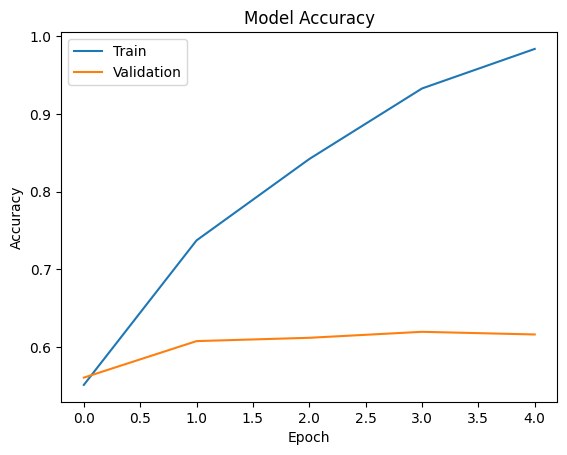

In [36]:
import matplotlib.pyplot as plt
# Print the keys of the history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [37]:
model_file_path = r'C:\Users\jmdgo\Downloads'
model.save("SoundRep_mzjs_model.h5")
print("Model saved successfully to:", model_file_path)

Model saved successfully to: C:\Users\jmdgo\Downloads
